In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 1000
beta = torch.linspace(10e-4, 0.02, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(2.5652e-05, device='cuda:0')

In [3]:
alpha_

tensor([9.9900e-01, 9.9798e-01, 9.9695e-01, 9.9589e-01, 9.9482e-01, 9.9373e-01,
        9.9262e-01, 9.9150e-01, 9.9036e-01, 9.8920e-01, 9.8802e-01, 9.8682e-01,
        9.8561e-01, 9.8438e-01, 9.8314e-01, 9.8187e-01, 9.8059e-01, 9.7930e-01,
        9.7798e-01, 9.7665e-01, 9.7530e-01, 9.7394e-01, 9.7255e-01, 9.7116e-01,
        9.6974e-01, 9.6831e-01, 9.6686e-01, 9.6540e-01, 9.6392e-01, 9.6243e-01,
        9.6091e-01, 9.5939e-01, 9.5784e-01, 9.5628e-01, 9.5471e-01, 9.5312e-01,
        9.5151e-01, 9.4989e-01, 9.4826e-01, 9.4660e-01, 9.4494e-01, 9.4326e-01,
        9.4156e-01, 9.3985e-01, 9.3812e-01, 9.3638e-01, 9.3463e-01, 9.3286e-01,
        9.3107e-01, 9.2927e-01, 9.2746e-01, 9.2563e-01, 9.2379e-01, 9.2194e-01,
        9.2007e-01, 9.1818e-01, 9.1629e-01, 9.1438e-01, 9.1246e-01, 9.1052e-01,
        9.0857e-01, 9.0661e-01, 9.0463e-01, 9.0264e-01, 9.0064e-01, 8.9863e-01,
        8.9660e-01, 8.9456e-01, 8.9251e-01, 8.9045e-01, 8.8837e-01, 8.8628e-01,
        8.8418e-01, 8.8207e-01, 8.7995e-

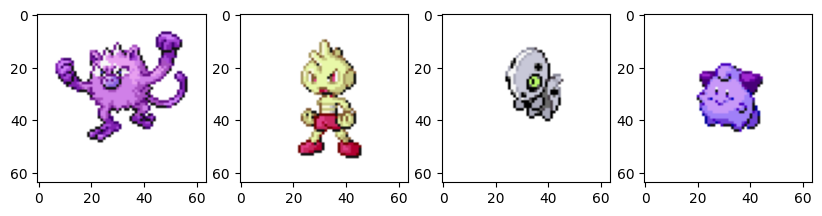

In [4]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
    #v2.GaussianBlur(kernel_size=9, sigma=(1,1))
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
pimages.min(), pimages.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [6]:
def isigmoid(x):
    eps = 0.1
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [7]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    #cont = contour[1, 151]
    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device)

        #xn = torch.cat([x, cont], dim=0)
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
    plot_image(torch.sigmoid(x))
    plt.show()

    model.train()

  0%|                                                                                                                                       | 0/100001 [00:00<?, ?it/s]

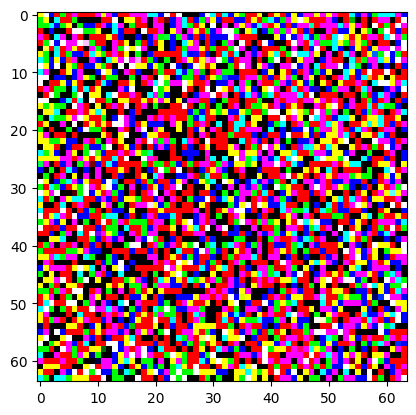

0.11406919:   1%|█                                                                                                              | 999/100001 [01:22<2:06:07, 13.08it/s]

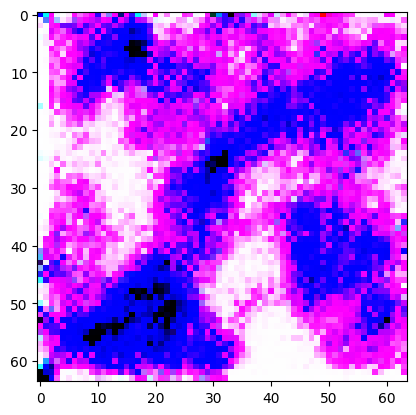

0.07068749:   2%|██▏                                                                                                           | 1999/100001 [02:44<2:04:54, 13.08it/s]

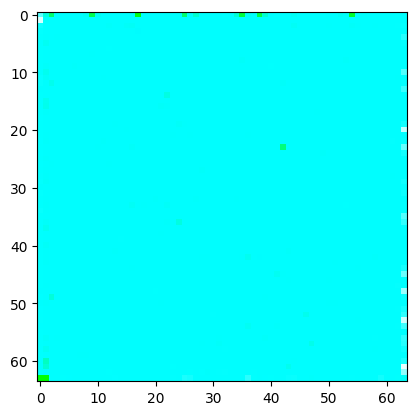

0.05747363:   3%|███▎                                                                                                          | 2999/100001 [04:06<2:03:22, 13.10it/s]

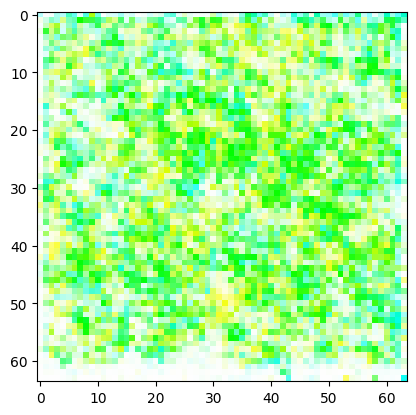

0.05287570:   4%|████▍                                                                                                         | 3999/100001 [05:28<2:01:53, 13.13it/s]

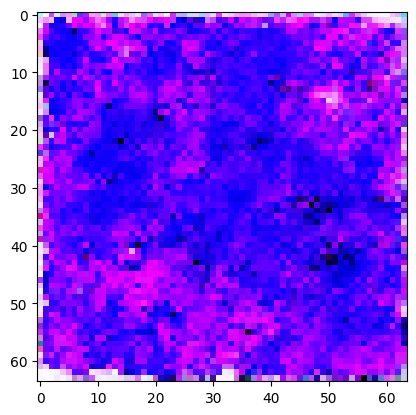

0.03614189:   5%|█████▍                                                                                                        | 4999/100001 [06:50<2:00:39, 13.12it/s]

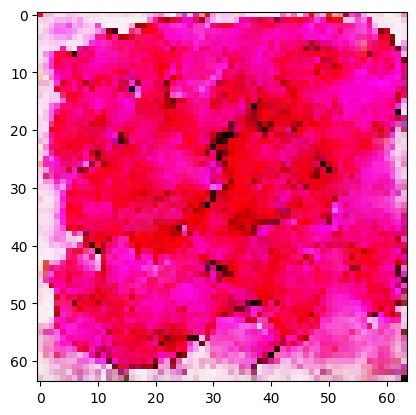

0.07371110:   6%|██████▌                                                                                                       | 5999/100001 [08:12<1:59:25, 13.12it/s]

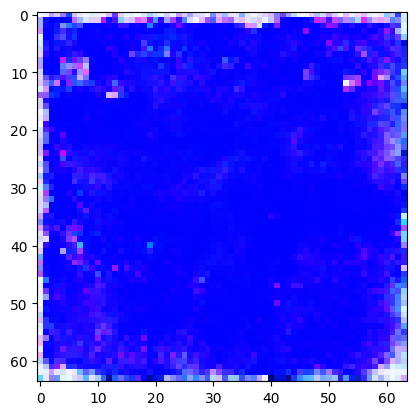

0.03020673:   7%|███████▋                                                                                                      | 6999/100001 [09:34<1:58:13, 13.11it/s]

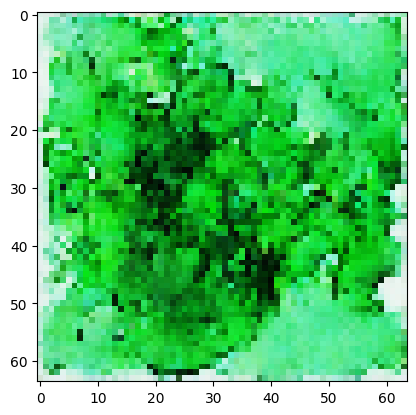

0.02990501:   8%|████████▊                                                                                                     | 7999/100001 [10:56<1:56:58, 13.11it/s]

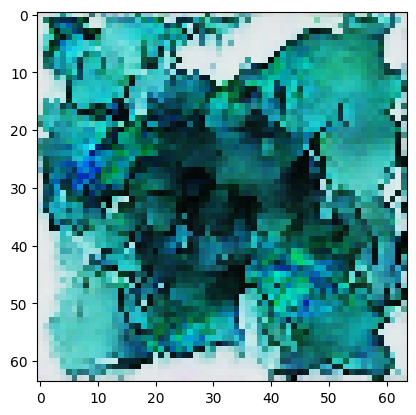

0.02537392:   9%|█████████▉                                                                                                    | 8999/100001 [12:18<1:55:37, 13.12it/s]

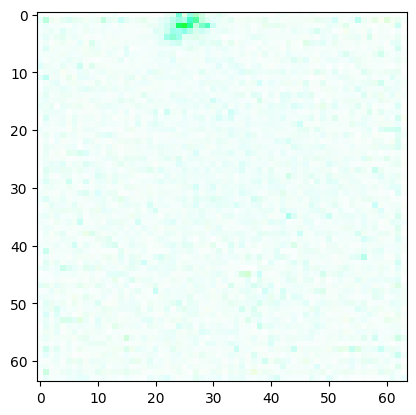

0.02156531:  10%|██████████▉                                                                                                   | 9999/100001 [13:40<1:54:23, 13.11it/s]

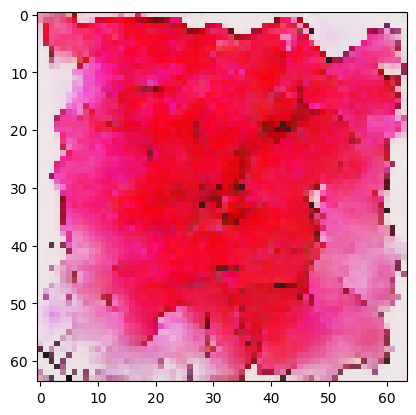

0.04052425:  11%|███████████▉                                                                                                 | 10999/100001 [15:02<1:53:16, 13.10it/s]

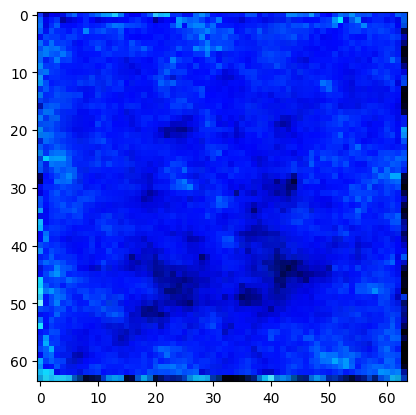

0.00878614:  12%|█████████████                                                                                                | 11999/100001 [16:24<1:51:49, 13.12it/s]

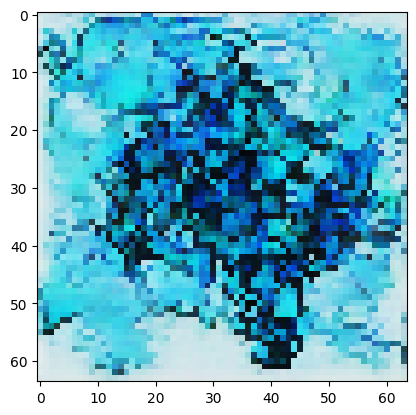

0.03057357:  13%|██████████████▏                                                                                              | 12999/100001 [17:46<1:50:49, 13.08it/s]

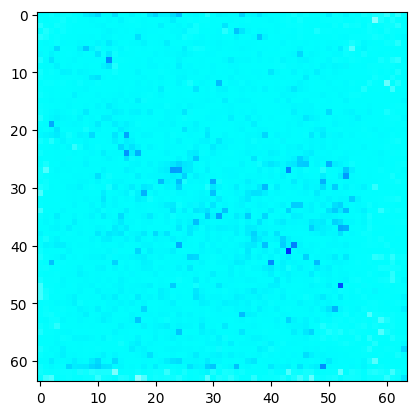

0.03627667:  14%|███████████████▎                                                                                             | 13999/100001 [19:08<1:49:17, 13.11it/s]

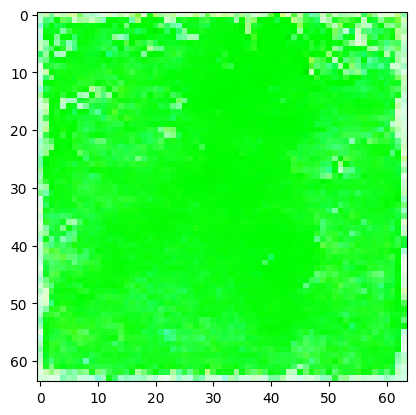

0.02160002:  15%|████████████████▎                                                                                            | 14999/100001 [20:30<1:48:05, 13.11it/s]

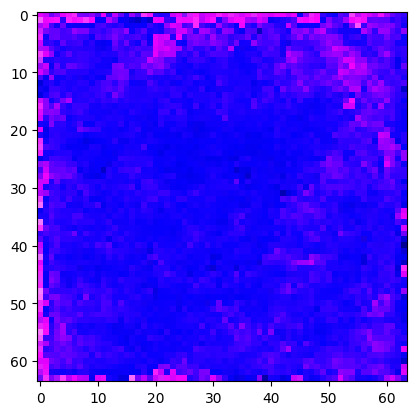

0.02501761:  16%|█████████████████▍                                                                                           | 15999/100001 [21:52<1:46:42, 13.12it/s]

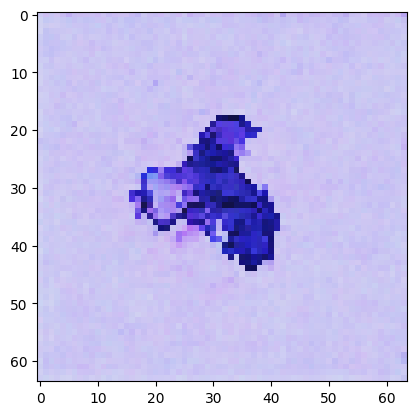

0.03123823:  17%|██████████████████▌                                                                                          | 16999/100001 [23:14<1:45:27, 13.12it/s]

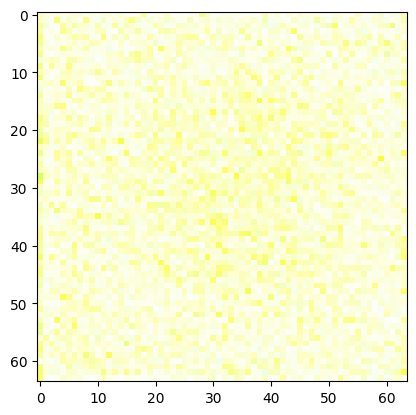

0.01448215:  18%|███████████████████▌                                                                                         | 17999/100001 [24:36<1:44:16, 13.11it/s]

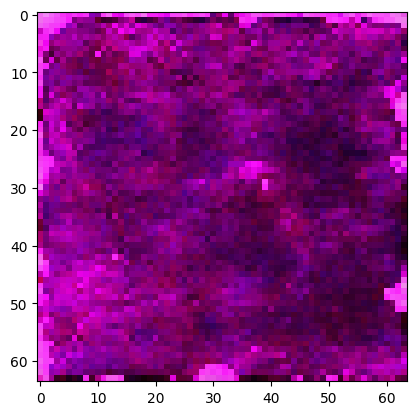

0.02324089:  19%|████████████████████▋                                                                                        | 18999/100001 [25:58<1:42:52, 13.12it/s]

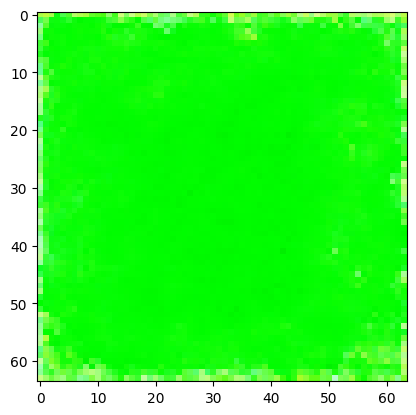

0.03816469:  20%|█████████████████████▊                                                                                       | 19999/100001 [27:20<1:41:31, 13.13it/s]

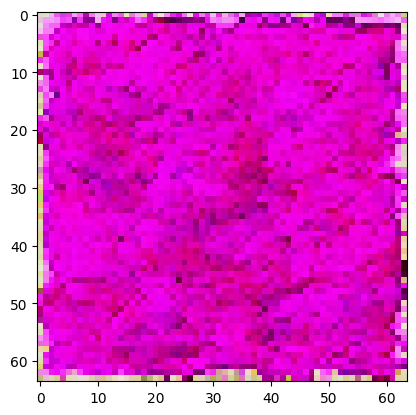

0.01891101:  21%|██████████████████████▉                                                                                      | 20999/100001 [28:42<1:40:28, 13.10it/s]

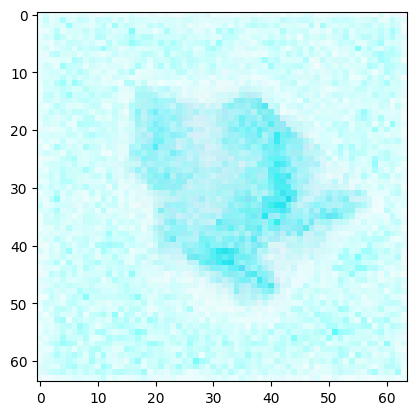

0.01484526:  22%|███████████████████████▉                                                                                     | 21999/100001 [30:04<1:39:15, 13.10it/s]

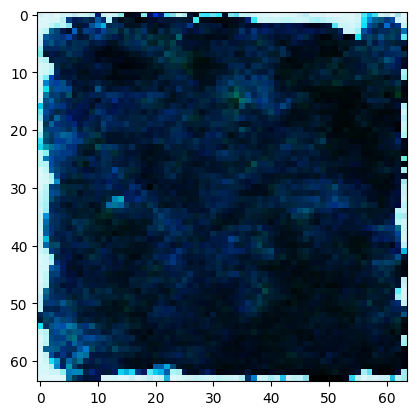

0.02610805:  23%|█████████████████████████                                                                                    | 22999/100001 [31:26<1:37:53, 13.11it/s]

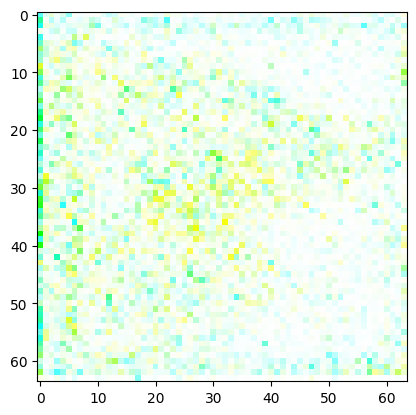

0.03067344:  24%|██████████████████████████▏                                                                                  | 23999/100001 [32:48<1:36:26, 13.13it/s]

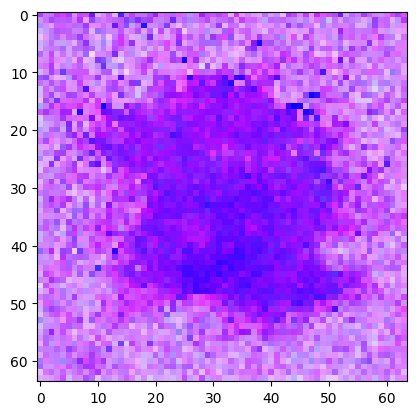

0.03109320:  25%|███████████████████████████▏                                                                                 | 24999/100001 [34:10<1:35:08, 13.14it/s]

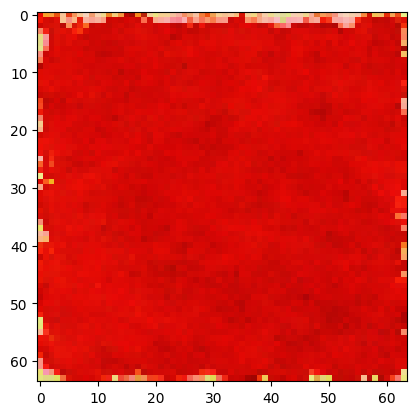

0.02878092:  26%|████████████████████████████▎                                                                                | 25999/100001 [35:32<1:34:05, 13.11it/s]

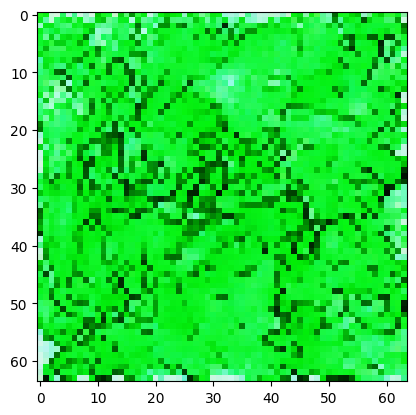

0.03795962:  27%|█████████████████████████████▍                                                                               | 26999/100001 [36:54<1:32:46, 13.12it/s]

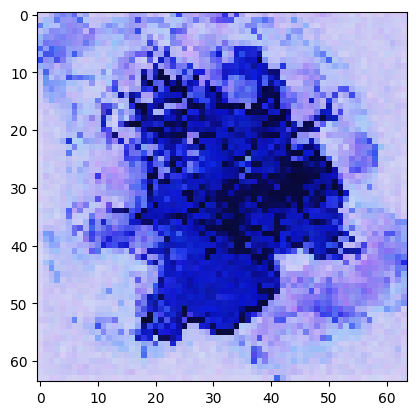

0.03650500:  28%|██████████████████████████████▌                                                                              | 27999/100001 [38:16<1:31:35, 13.10it/s]

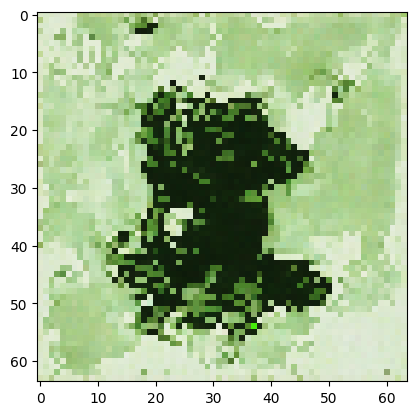

0.01873649:  29%|███████████████████████████████▌                                                                             | 28999/100001 [39:38<1:30:18, 13.10it/s]

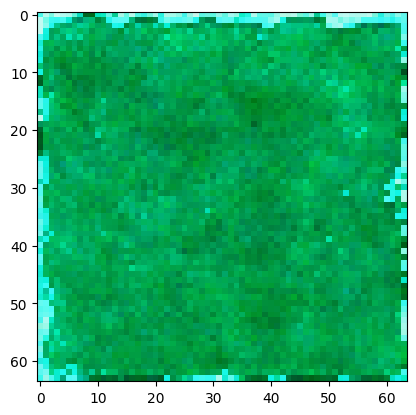

0.02676377:  30%|████████████████████████████████▋                                                                            | 29999/100001 [41:00<1:28:48, 13.14it/s]

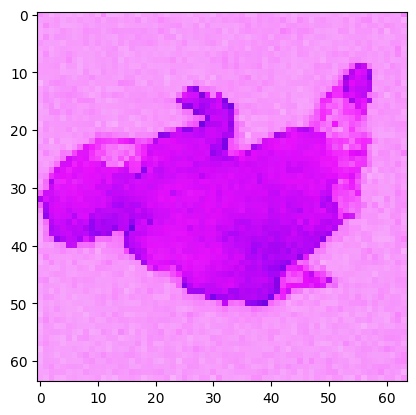

0.02329309:  31%|█████████████████████████████████▊                                                                           | 30999/100001 [42:22<1:27:44, 13.11it/s]

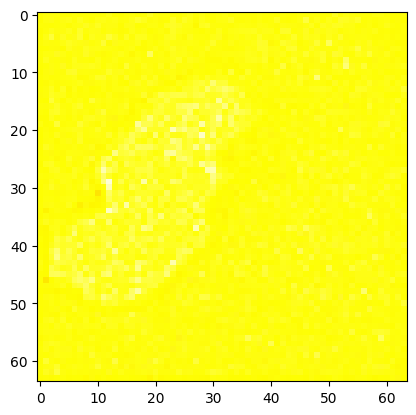

0.02036448:  32%|██████████████████████████████████▉                                                                          | 31999/100001 [43:44<1:26:30, 13.10it/s]

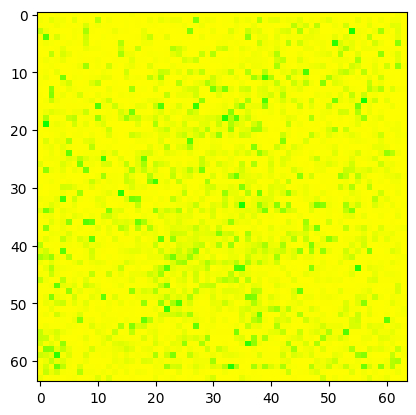

0.02445516:  33%|███████████████████████████████████▉                                                                         | 32999/100001 [45:06<1:25:04, 13.13it/s]

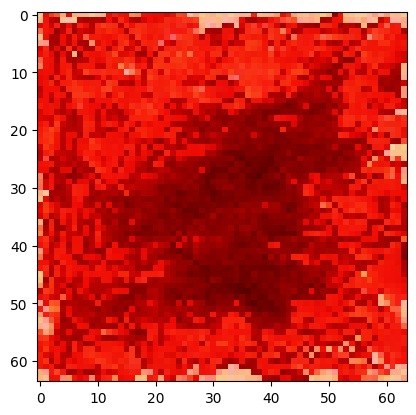

0.03865292:  34%|█████████████████████████████████████                                                                        | 33999/100001 [46:28<1:23:51, 13.12it/s]

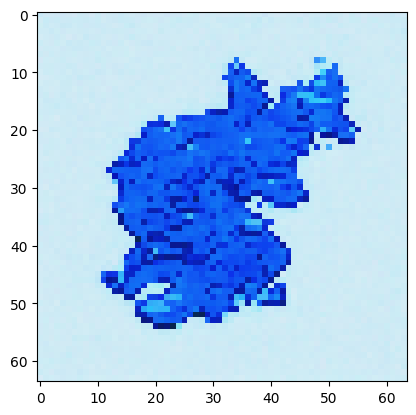

0.01338406:  35%|██████████████████████████████████████▏                                                                      | 34999/100001 [47:50<1:22:29, 13.13it/s]

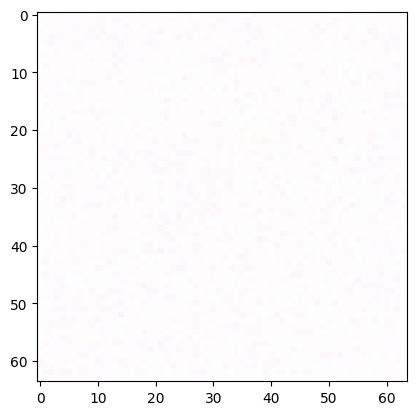

0.00793263:  36%|███████████████████████████████████████▏                                                                     | 35999/100001 [49:12<1:21:17, 13.12it/s]

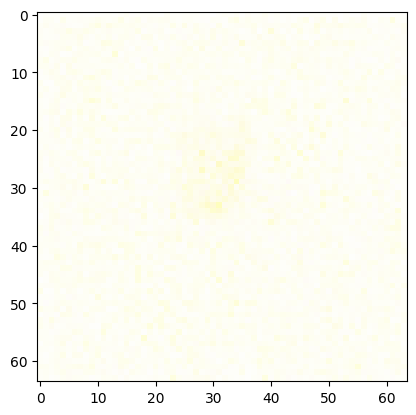

0.02226310:  37%|████████████████████████████████████████▎                                                                    | 36999/100001 [50:33<1:19:59, 13.13it/s]

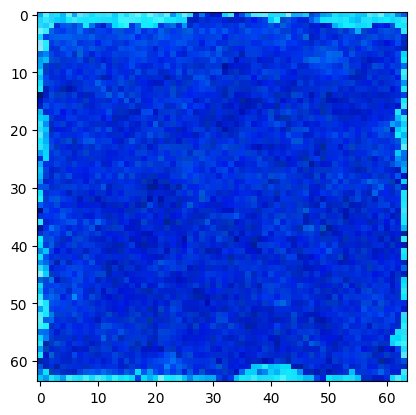

0.02831556:  38%|█████████████████████████████████████████▍                                                                   | 37999/100001 [51:55<1:18:47, 13.12it/s]

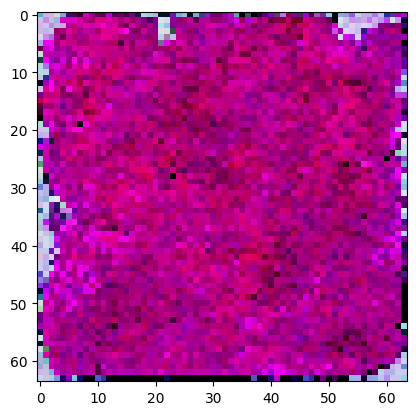

0.03802527:  39%|██████████████████████████████████████████▌                                                                  | 38999/100001 [53:18<1:17:24, 13.13it/s]

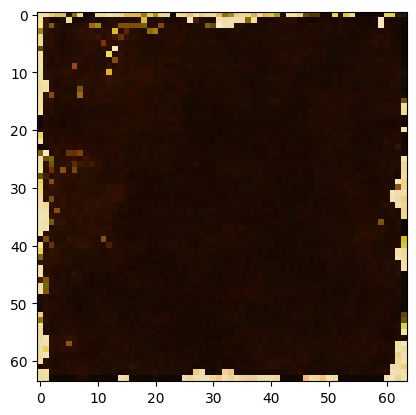

0.01693568:  40%|███████████████████████████████████████████▌                                                                 | 39999/100001 [54:39<1:16:11, 13.13it/s]

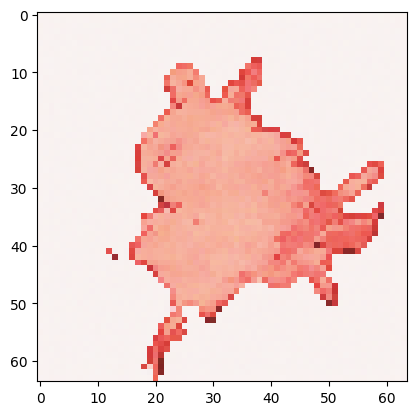

0.01638540:  41%|████████████████████████████████████████████▋                                                                | 40999/100001 [56:01<1:14:59, 13.11it/s]

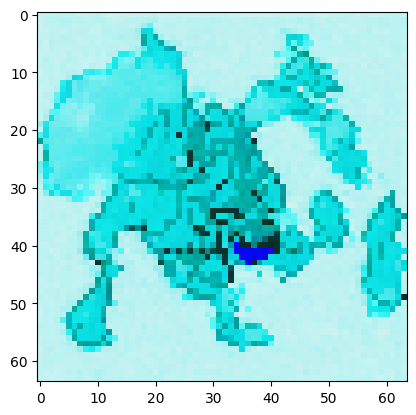

0.01011001:  42%|█████████████████████████████████████████████▊                                                               | 41999/100001 [57:23<1:13:36, 13.13it/s]

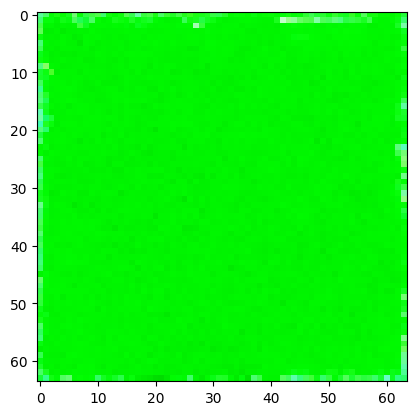

0.01954325:  43%|██████████████████████████████████████████████▊                                                              | 42999/100001 [58:45<1:12:23, 13.12it/s]

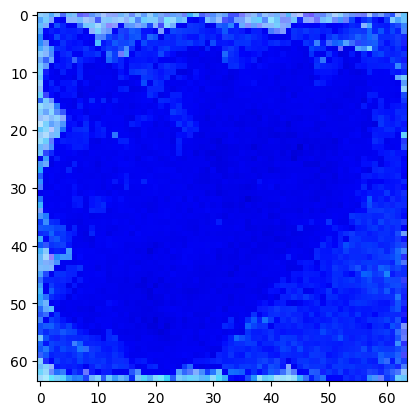

0.03208214:  44%|███████████████████████████████████████████████                                                            | 43999/100001 [1:00:07<1:11:08, 13.12it/s]

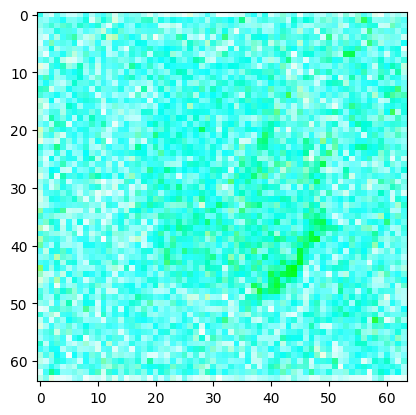

0.02574146:  45%|████████████████████████████████████████████████▏                                                          | 44999/100001 [1:01:29<1:09:55, 13.11it/s]

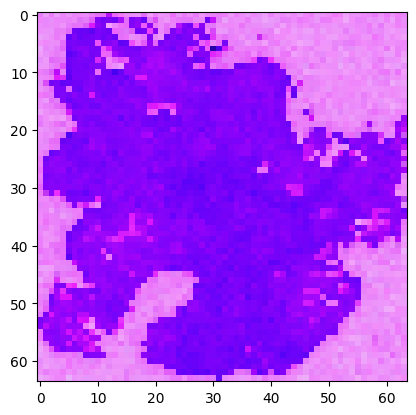

0.04343300:  46%|█████████████████████████████████████████████████▏                                                         | 45999/100001 [1:02:51<1:08:37, 13.12it/s]

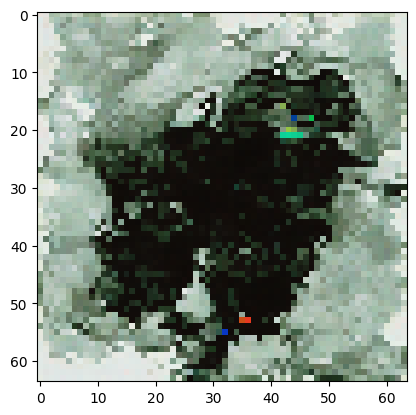

0.01908564:  47%|██████████████████████████████████████████████████▎                                                        | 46999/100001 [1:04:13<1:07:19, 13.12it/s]

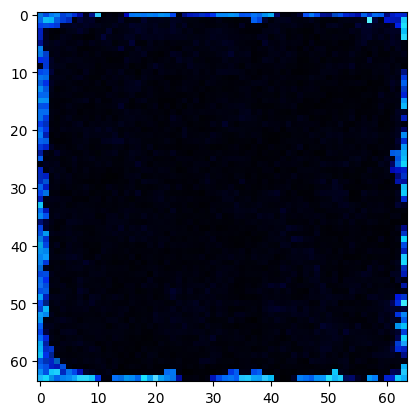

0.01699007:  48%|███████████████████████████████████████████████████▎                                                       | 47999/100001 [1:05:35<1:06:01, 13.13it/s]

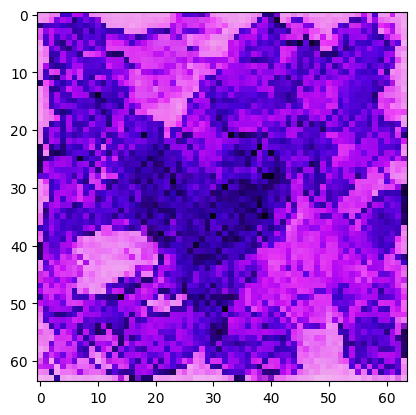

0.02631903:  49%|████████████████████████████████████████████████████▍                                                      | 48999/100001 [1:06:57<1:04:41, 13.14it/s]

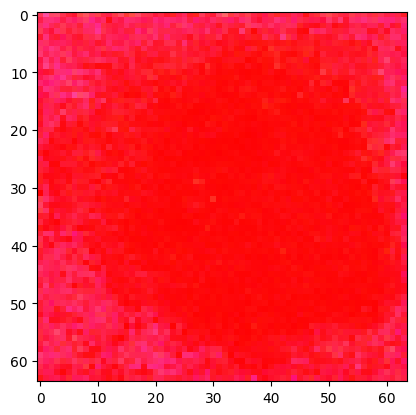

0.02070256:  50%|█████████████████████████████████████████████████████▍                                                     | 49999/100001 [1:08:19<1:03:30, 13.12it/s]

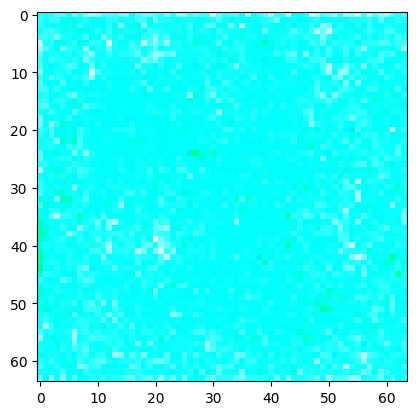

0.03127487:  51%|██████████████████████████████████████████████████████▌                                                    | 50999/100001 [1:09:41<1:02:07, 13.14it/s]

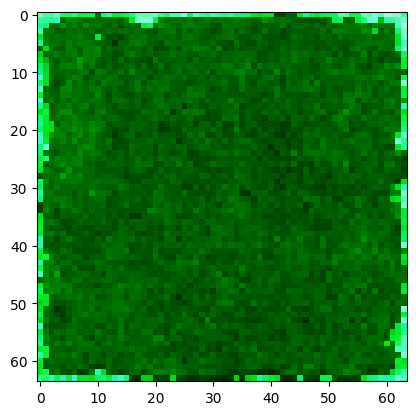

0.01668723:  52%|███████████████████████████████████████████████████████▋                                                   | 51999/100001 [1:11:03<1:00:58, 13.12it/s]

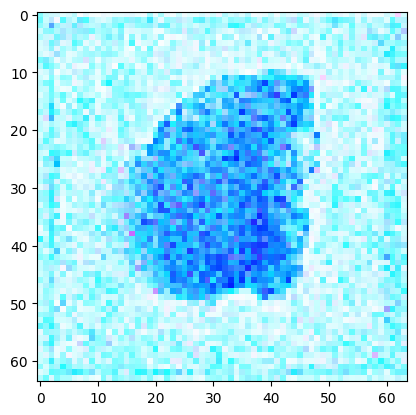

0.02464663:  53%|█████████████████████████████████████████████████████████▊                                                   | 52999/100001 [1:12:25<59:42, 13.12it/s]

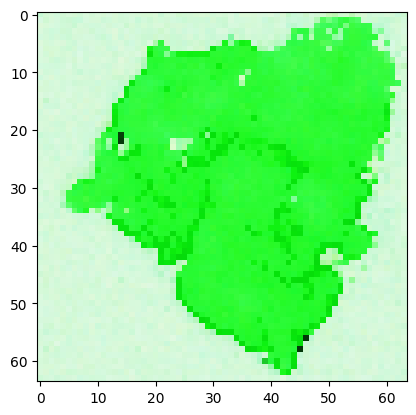

0.02929668:  54%|██████████████████████████████████████████████████████████▊                                                  | 53999/100001 [1:13:47<58:25, 13.12it/s]

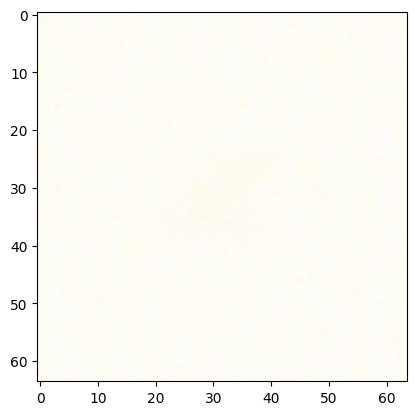

0.02283881:  55%|███████████████████████████████████████████████████████████▉                                                 | 54999/100001 [1:15:09<57:10, 13.12it/s]

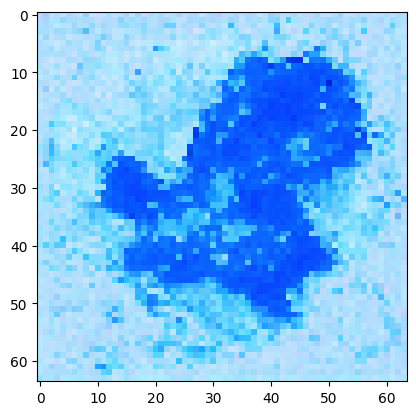

0.01856128:  56%|█████████████████████████████████████████████████████████████                                                | 55999/100001 [1:16:31<55:54, 13.12it/s]

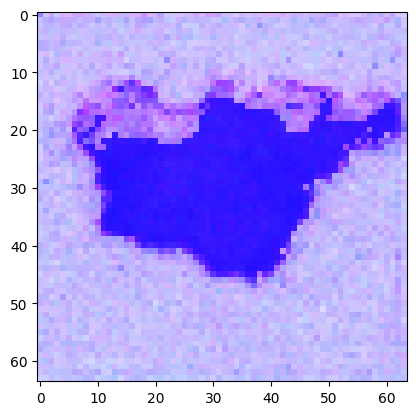

0.02083484:  57%|██████████████████████████████████████████████████████████████▏                                              | 56999/100001 [1:17:53<54:33, 13.13it/s]

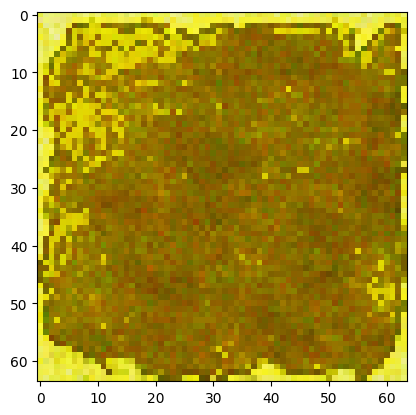

0.01990207:  58%|███████████████████████████████████████████████████████████████▏                                             | 57999/100001 [1:19:15<53:21, 13.12it/s]

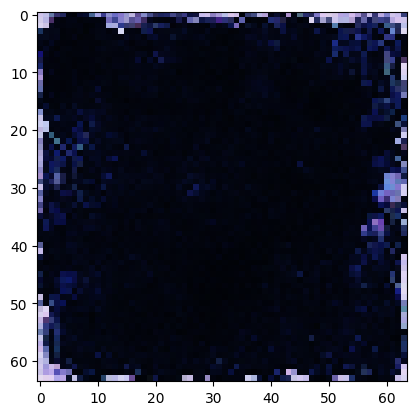

0.02110013:  59%|████████████████████████████████████████████████████████████████▎                                            | 58999/100001 [1:20:37<52:03, 13.13it/s]

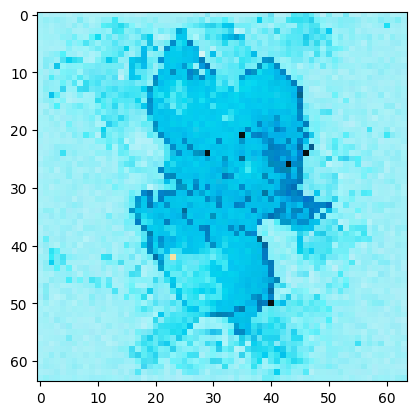

0.02301705:  60%|█████████████████████████████████████████████████████████████████▍                                           | 59999/100001 [1:21:59<50:47, 13.12it/s]

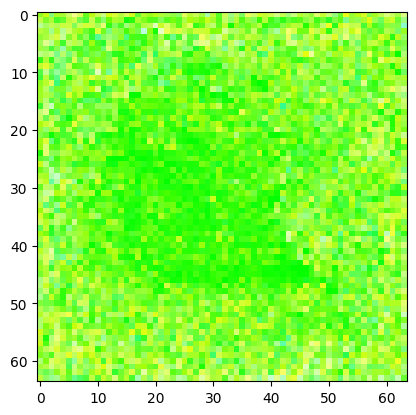

0.01701938:  61%|██████████████████████████████████████████████████████████████████▍                                          | 60999/100001 [1:23:21<49:23, 13.16it/s]

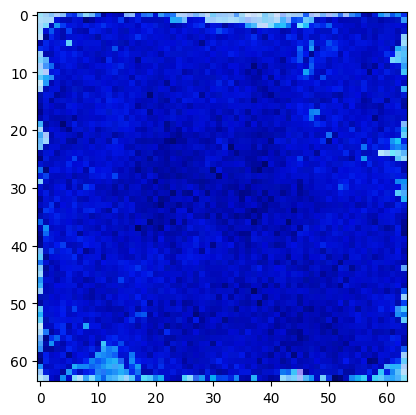

0.04109337:  62%|███████████████████████████████████████████████████████████████████▌                                         | 61999/100001 [1:24:43<48:15, 13.12it/s]

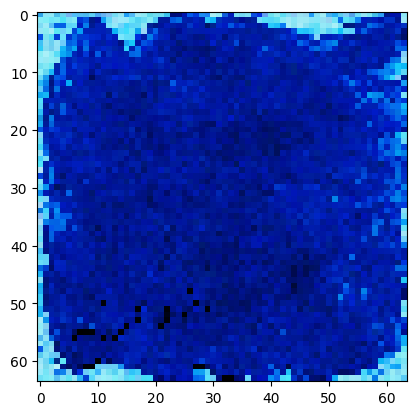

0.01040937:  63%|████████████████████████████████████████████████████████████████████▋                                        | 62999/100001 [1:26:05<46:58, 13.13it/s]

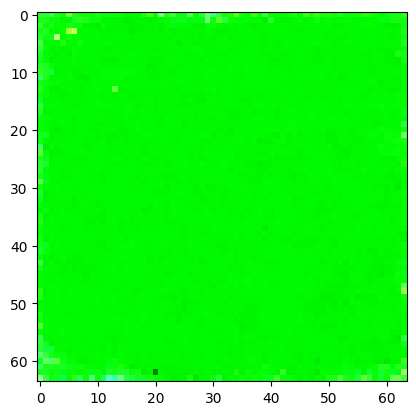

0.01672454:  64%|█████████████████████████████████████████████████████████████████████▊                                       | 63999/100001 [1:27:27<46:05, 13.02it/s]

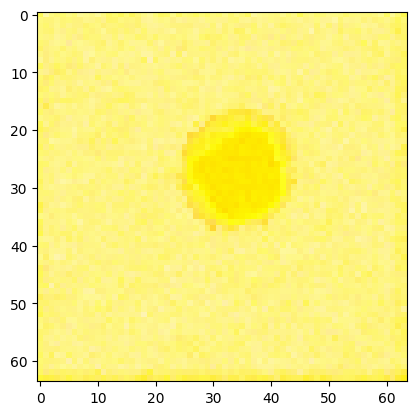

0.02536295:  65%|██████████████████████████████████████████████████████████████████████▊                                      | 64999/100001 [1:28:49<44:31, 13.10it/s]

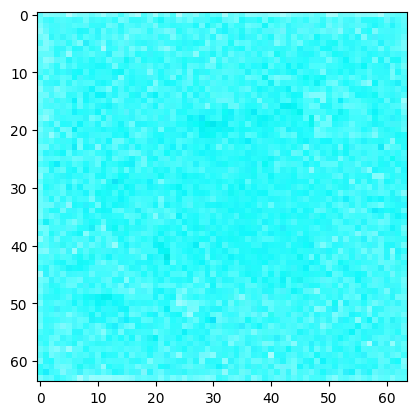

0.01151928:  66%|███████████████████████████████████████████████████████████████████████▉                                     | 65999/100001 [1:30:11<43:10, 13.12it/s]

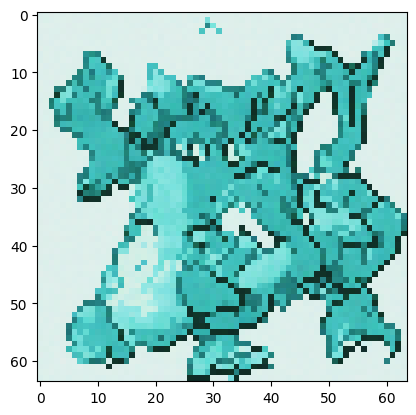

0.03888190:  67%|█████████████████████████████████████████████████████████████████████████                                    | 66999/100001 [1:31:33<41:52, 13.13it/s]

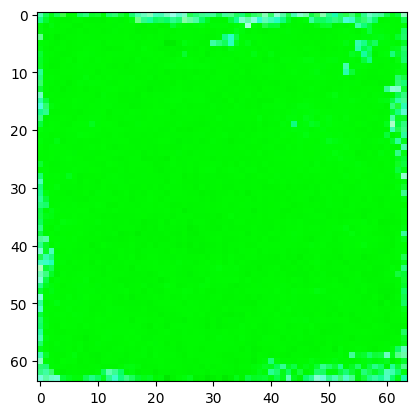

0.01951825:  68%|██████████████████████████████████████████████████████████████████████████                                   | 67999/100001 [1:32:55<40:40, 13.11it/s]

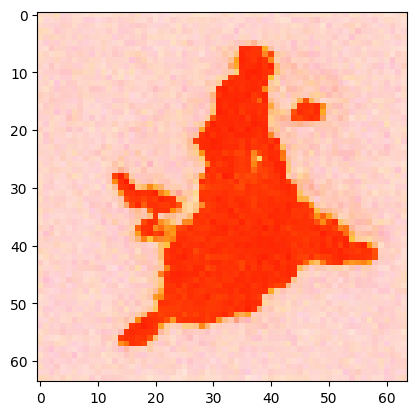

0.01159597:  69%|███████████████████████████████████████████████████████████████████████████▏                                 | 68999/100001 [1:34:17<39:21, 13.13it/s]

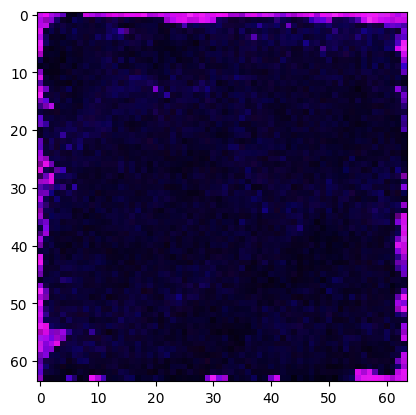

0.01744296:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 69999/100001 [1:35:39<38:05, 13.13it/s]

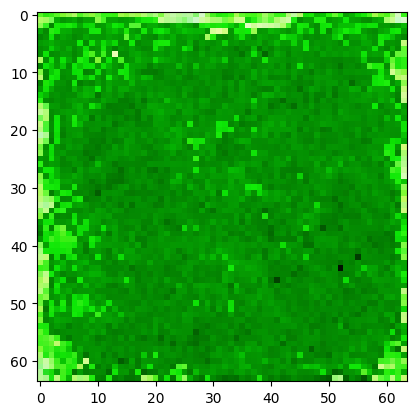

0.02160342:  71%|█████████████████████████████████████████████████████████████████████████████▍                               | 70999/100001 [1:37:01<36:52, 13.11it/s]

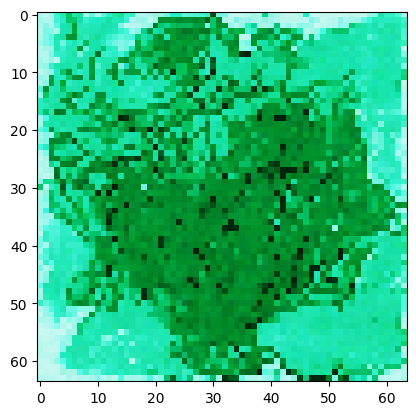

0.03853319:  72%|██████████████████████████████████████████████████████████████████████████████▍                              | 71999/100001 [1:38:23<35:31, 13.14it/s]

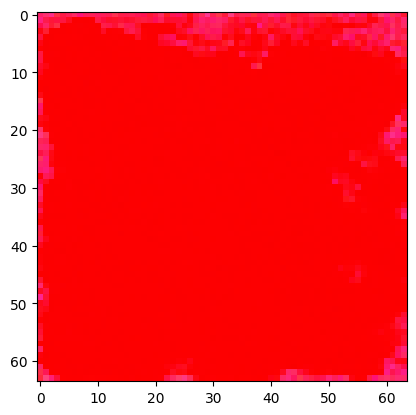

0.03450733:  73%|███████████████████████████████████████████████████████████████████████████████▌                             | 72999/100001 [1:39:45<34:18, 13.12it/s]

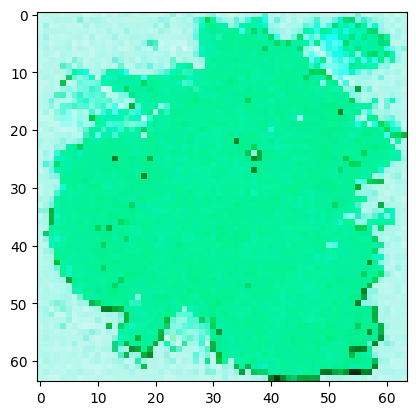

0.02642703:  74%|████████████████████████████████████████████████████████████████████████████████▋                            | 73999/100001 [1:41:06<32:59, 13.14it/s]

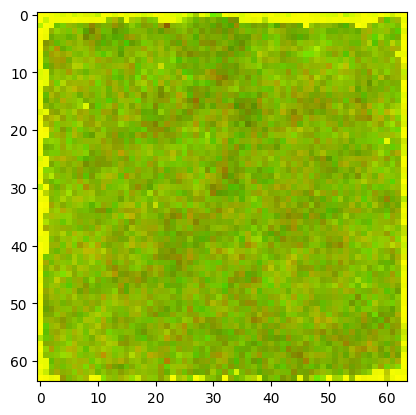

0.02528524:  75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 74999/100001 [1:42:28<31:43, 13.13it/s]

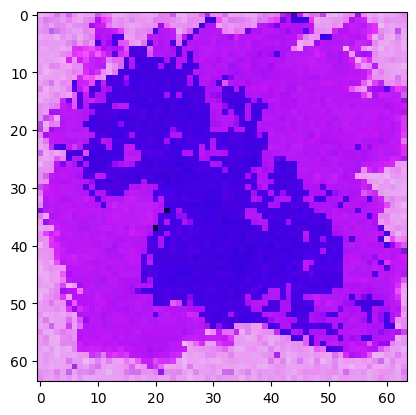

0.03949118:  76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 75999/100001 [1:43:50<30:30, 13.11it/s]

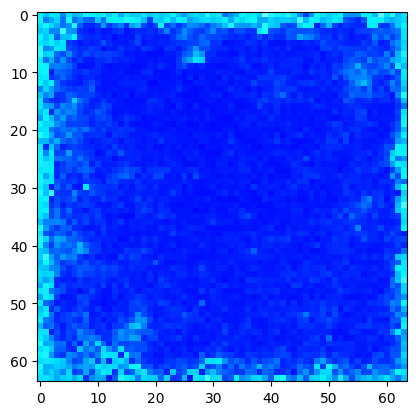

0.01380812:  77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 76999/100001 [1:45:12<29:14, 13.11it/s]

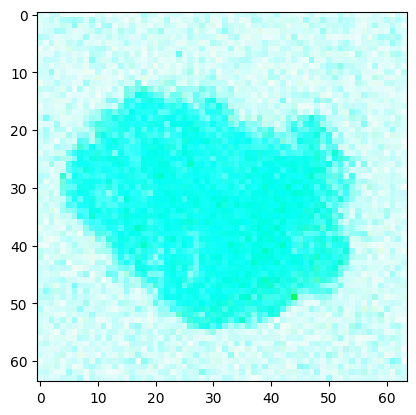

0.03598465:  78%|█████████████████████████████████████████████████████████████████████████████████████                        | 77999/100001 [1:46:34<27:55, 13.13it/s]

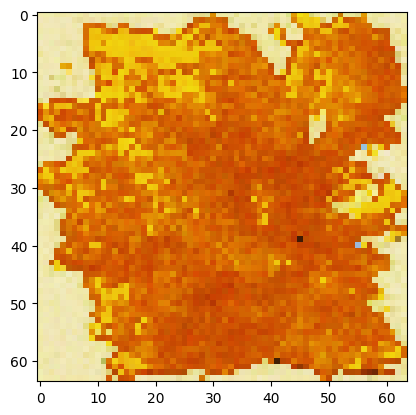

0.04296854:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 78999/100001 [1:47:56<26:39, 13.13it/s]

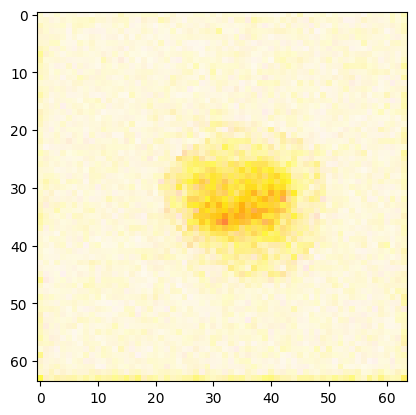

0.03104807:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 79999/100001 [1:49:18<25:24, 13.12it/s]

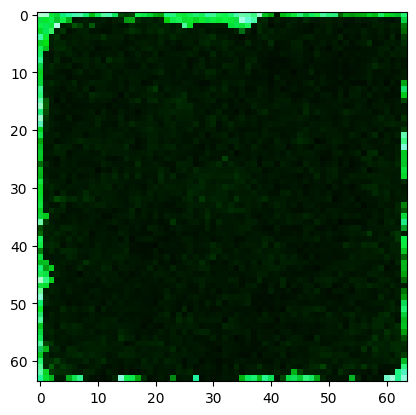

0.03969568:  81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 80999/100001 [1:50:40<24:09, 13.11it/s]

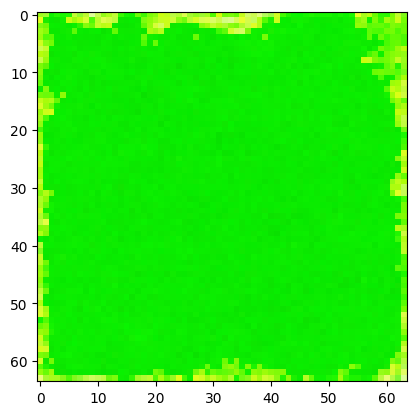

0.03545752:  82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 81999/100001 [1:52:02<22:50, 13.13it/s]

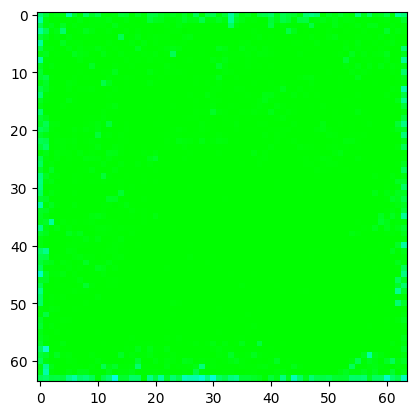

0.03976685:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 82999/100001 [1:53:24<21:36, 13.11it/s]

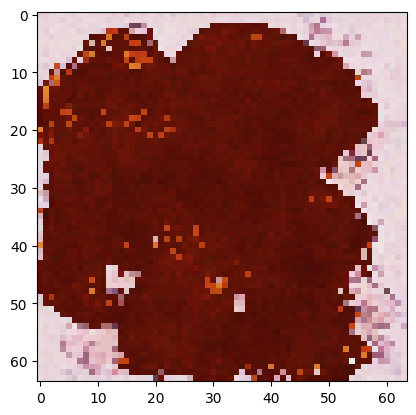

0.01159381:  84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 83999/100001 [1:54:46<20:18, 13.13it/s]

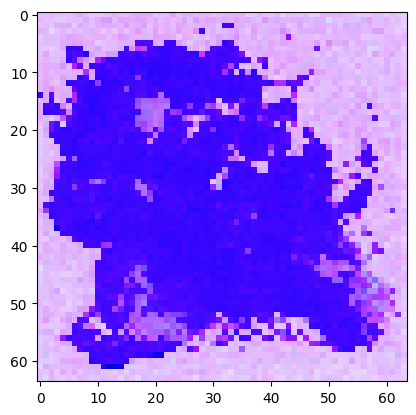

0.03402518:  85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 84999/100001 [1:56:08<19:01, 13.14it/s]

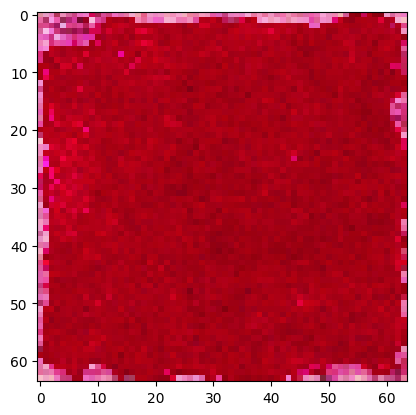

0.02496970:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 85999/100001 [1:57:30<17:46, 13.13it/s]

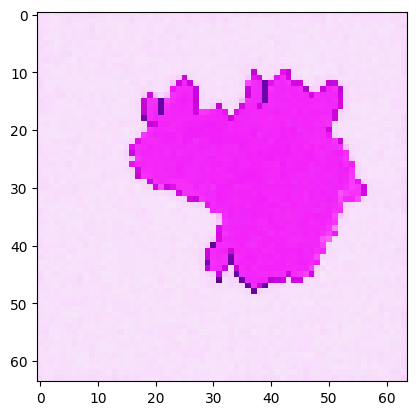

0.03762911:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 86999/100001 [1:58:52<16:32, 13.10it/s]

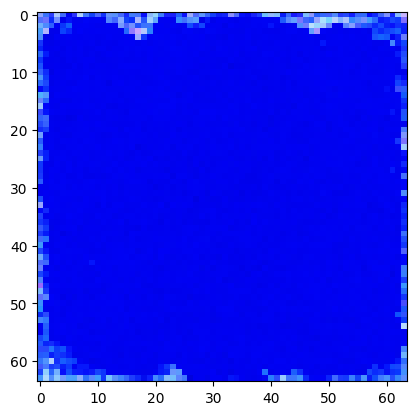

0.01839506:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 87999/100001 [2:00:14<15:12, 13.15it/s]

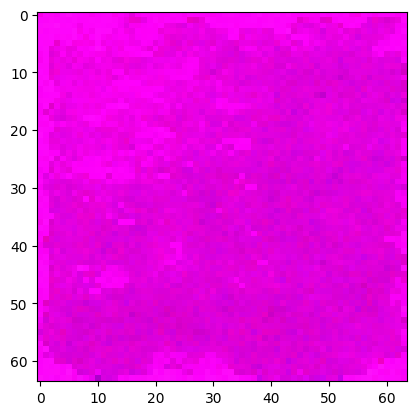

0.04102410:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 88999/100001 [2:01:36<13:57, 13.13it/s]

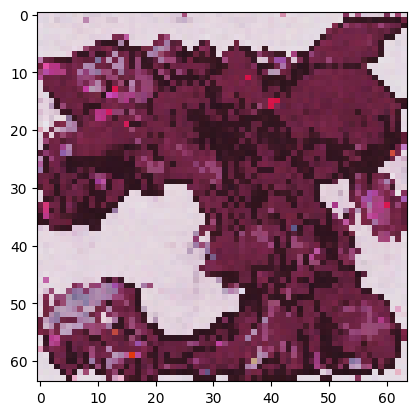

0.02788110:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 89999/100001 [2:02:58<12:41, 13.14it/s]

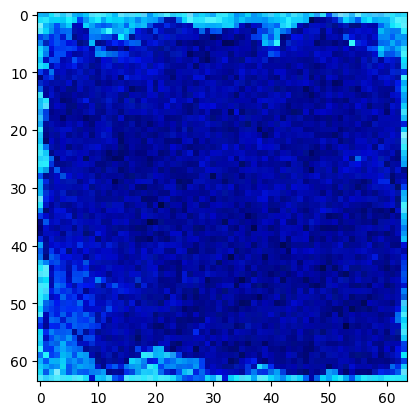

0.02596114:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 90999/100001 [2:04:20<11:27, 13.10it/s]

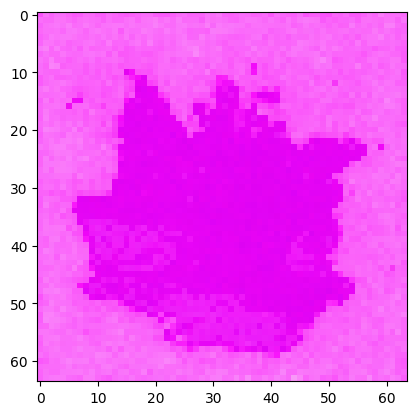

0.02681978:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 91999/100001 [2:05:42<10:09, 13.12it/s]

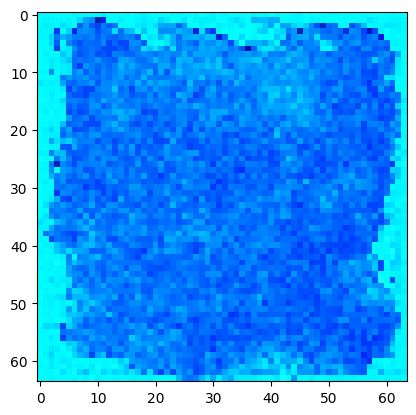

0.03949051:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 92999/100001 [2:07:04<08:53, 13.12it/s]

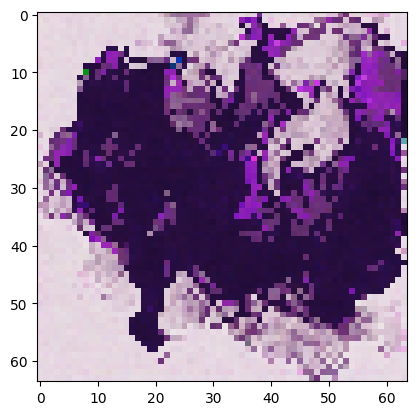

0.01634404:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 93999/100001 [2:08:25<07:37, 13.11it/s]

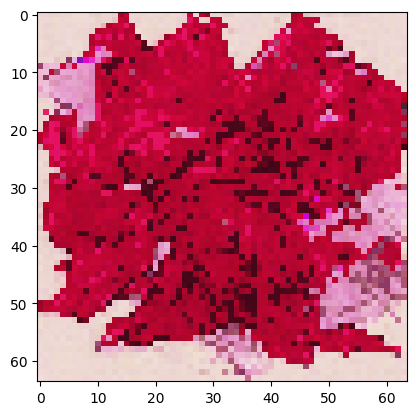

0.04175349:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 94999/100001 [2:09:47<06:21, 13.12it/s]

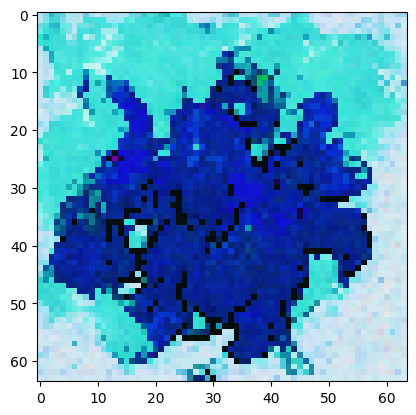

0.02367567:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 95999/100001 [2:11:09<05:05, 13.10it/s]

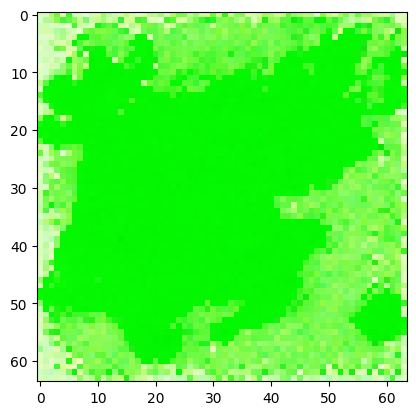

0.01449474:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 96999/100001 [2:12:31<03:48, 13.13it/s]

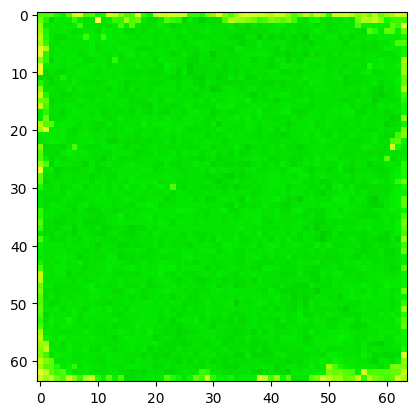

0.02565066:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 97999/100001 [2:13:53<02:32, 13.14it/s]

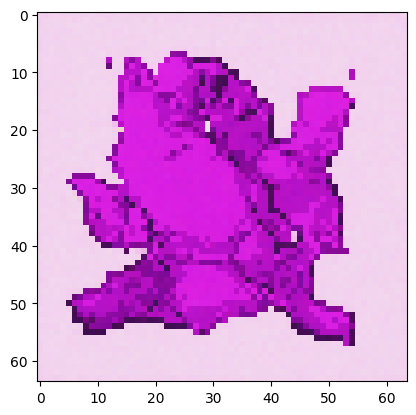

0.01935866:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 98999/100001 [2:15:15<01:16, 13.14it/s]

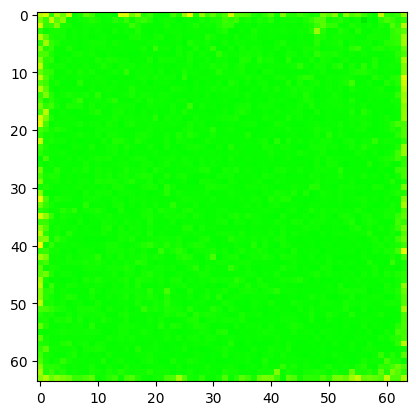

0.01280762: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 99999/100001 [2:16:37<00:00, 13.14it/s]

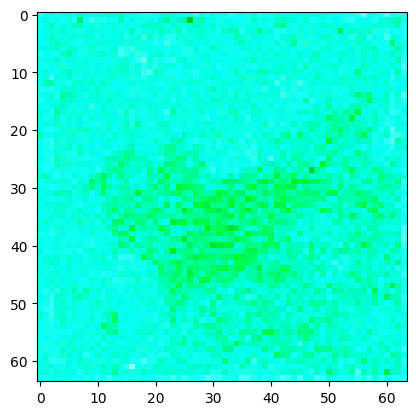

0.02111380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [2:16:43<00:00, 12.19it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn(x0.shape, device=device)
    t = torch.randint(0, T - 1, (bs,), device=device)

    x_nois = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    #xc = contour[source, batch]
    #xn = torch.cat([x_nois, xc], dim=1)

    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')